In [3]:
# SVI for a mixture of 3 Gaussians in 2d
# https://github.com/brendanhasz/svi-gaussian-mixture-model/blob/master/BayesianGaussianMixtureModel.ipynb

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import tensorflow as tf
except ModuleNotFoundError:
    %pip install -qq tensorflow
    import tensorflow as tf
try:
    import tensorflow_probability as tfp
except ModuleNotFoundError:
    %pip install -qq tensorflow-probability
    import tensorflow_probability as tfp
tfd = tfp.distributions

try:
    import probml_utils.svi_gmm_model_tfp as GMM
except ModuleNotFoundError:
    %pip install -qq svi_gmm_model_tfp
    import probml_utils.svi_gmm_model_tfp as GMM

from probml_utils import savefig
import numpy as np
import matplotlib.pyplot as plt
import os

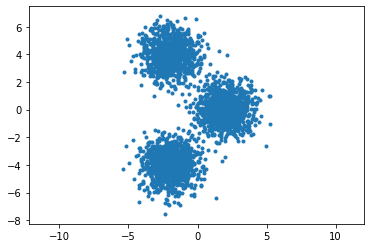

2022-06-26 17:17:04.546172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-26 17:17:05.135643: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:d8:00.0, compute capability: 6.1
/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


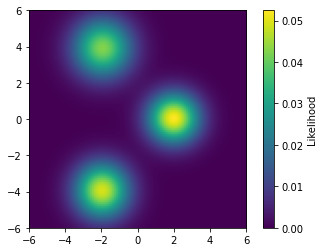

/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


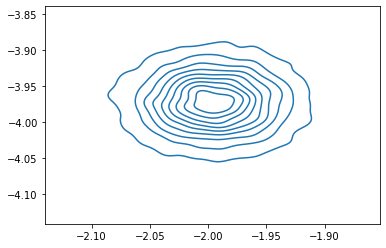

In [4]:
figdir = "../figures"


# Random seed
np.random.seed(12345)
tf.random.set_seed(12345)

# Generate some data
N = 3000
X = np.random.randn(N, 2).astype("float32")
X[:1000, :] += [2, 0]
X[1000:2000, :] -= [2, 4]
X[2000:, :] += [-2, 4]

# Plot the data
plt.figure()
plt.plot(X[:, 0], X[:, 1], ".")
plt.axis("equal")
savefig("svi_gmm_2d_data.pdf")
plt.show()

# Make a TensorFlow Dataset from that data
batch_size = 500
dataset = tf.data.Dataset.from_tensor_slices((X)).shuffle(10000).batch(batch_size)

# A GMM with 3 components in 2 dimensions
model = GMM.GaussianMixtureModel(3, 2)

nepochs = 1000
model.fit(dataset, N, nepochs)

# Compute log likelihood at each point on a grid
Np = 100  # number of grid points
Xp, Yp = np.meshgrid(np.linspace(-6, 6, Np), np.linspace(-6, 6, Np))
Pp = np.column_stack([Xp.flatten(), Yp.flatten()]).astype("float32")
Z, _ = model(Pp, sampling=False)
Z = np.reshape(Z, (Np, Np))

# Show the fit mixture density
plt.figure()
plt.imshow(np.exp(Z), extent=(-6, 6, -6, 6), origin="lower")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Likelihood")
savefig("svi_gmm_2d_fit.pdf")
plt.show()

# Sample from the mean variational posterior
means = tfd.Normal(model.locs, model.scales).sample(10000)

# Plot the mean samples for a single
plt.figure()
sns.kdeplot(means[:, 0, 0].numpy(), means[:, 0, 1].numpy(), n_levels=10)
savefig("svi_gmm_2d_post_mean_comp0.pdf")
plt.show()